# Binary classification of alpacas using MobileNetV2 with Fine Tuning

**Dataset** from [**Kaggle**](https://www.kaggle.com/datasets/sid4sal/alpaca-dataset-small)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
IMAGES_PATH = "alpaca_dataset/"
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32
IMAGE_SIZE = (160, 160)
IMAGE_SHAPE = IMAGE_SIZE + (3,)
DROPOUT_RATIO = 0.3
LEARNING_RATE = 0.001
INITIAL_EPOCHS = 10
FINE_TUNING_EPOCHS = 10

## Loading data

In [3]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=IMAGES_PATH,
    validation_split=VALIDATION_SPLIT,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    subset='training',
    seed=42
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=IMAGES_PATH,
    validation_split=VALIDATION_SPLIT,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    subset='validation',
    seed=42
)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


In [4]:
class_names = train_dataset.class_names

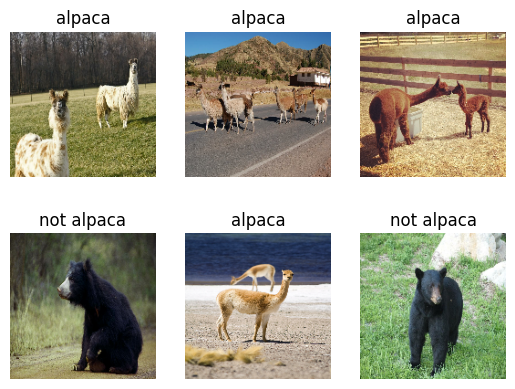

In [5]:
for images, labels in train_dataset.take(1):
    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.axis('off')
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])

## Data preprocessing

Configuring a dataset for performance

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

## Transfer Learning

Building a base model from pre-trained convnets

In [7]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    weights='imagenet'
)

Base model architecture

In [ ]:
base_model.summary()

In [ ]:
tf.keras.utils.plot_model(base_model, show_shapes=True, expand_nested=True)

Freezing a convolutional base

In [8]:
base_model.trainable = False

Building a model

In [9]:
inputs = tf.keras.Input(IMAGE_SHAPE)
x = inputs
x = tf.keras.layers.RandomFlip('horizontal')(x) # Data aumentation
x = tf.keras.layers.RandomRotation(0.2)(x) # Data augmentation
x = tf.keras.applications.mobilenet_v2.preprocess_input(x) # Input normalization
x = base_model(x, training=False) # Convolutional base layers
x = tf.keras.layers.GlobalAveragePooling2D()(x) # Global average layer
x = tf.keras.layers.Dropout(DROPOUT_RATIO)(x) # Dropout layer
x = tf.keras.layers.Dense(1, activation='sigmoid')(x) # Prediction layer
outputs = x

model = tf.keras.Model(inputs, outputs)

Model compilation

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

Model training

In [11]:
history = model.fit(
    x=train_dataset,
    epochs=INITIAL_EPOCHS,
    validation_data=validation_dataset
)

Epoch 1/10
9/9 [==============================] - 42s 3s/step - loss: 0.9042 - accuracy: 0.5153 - val_loss: 0.5552 - val_accuracy: 0.7538
Epoch 2/10
9/9 [==============================] - 18s 2s/step - loss: 0.6615 - accuracy: 0.6641 - val_loss: 0.4368 - val_accuracy: 0.8308
Epoch 3/10
9/9 [==============================] - 18s 2s/step - loss: 0.5794 - accuracy: 0.7328 - val_loss: 0.3909 - val_accuracy: 0.8154
Epoch 4/10
9/9 [==============================] - 17s 2s/step - loss: 0.4914 - accuracy: 0.7824 - val_loss: 0.3252 - val_accuracy: 0.8615
Epoch 5/10
9/9 [==============================] - 19s 2s/step - loss: 0.4832 - accuracy: 0.7863 - val_loss: 0.2877 - val_accuracy: 0.9077
Epoch 6/10
9/9 [==============================] - 17s 2s/step - loss: 0.4187 - accuracy: 0.8053 - val_loss: 0.2827 - val_accuracy: 0.8615
Epoch 7/10
9/9 [==============================] - 17s 2s/step - loss: 0.3844 - accuracy: 0.8206 - val_loss: 0.2475 - val_accuracy: 0.9385
Epoch 8/10
9/9 [==================

Learning curves

In [12]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

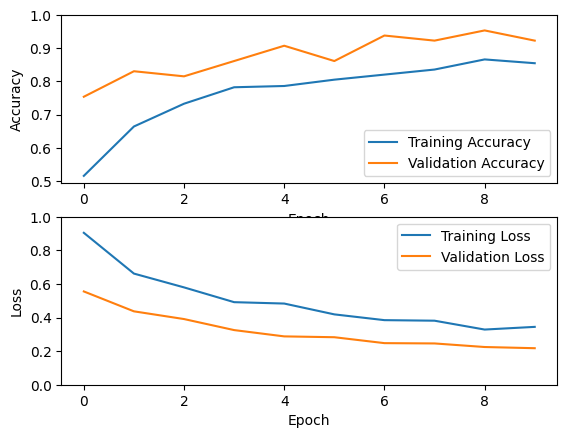

In [13]:
plt.subplot(2, 1, 1)
plt.plot(accuracy, label="Training Accuracy")
plt.plot(val_accuracy, label="Validation Accuracy")
plt.ylim([min(plt.ylim()), 1])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.ylim([0, 1])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='upper right')

plt.show()

## Fine tuning

Unfreezing a convolutional base

In [14]:
base_model.trainable = True

fine_tuning_at = 100
for layer in base_model.layers[:fine_tuning_at]:
    layer.trainable = False

Model compilation

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1*LEARNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

Model training

In [16]:
history_fine_tuning = model.fit(
    x=train_dataset,
    epochs=INITIAL_EPOCHS+FINE_TUNING_EPOCHS,
    initial_epoch=history.epoch[-1]+1,
    validation_data=validation_dataset
)

Epoch 11/20
9/9 [==============================] - 45s 3s/step - loss: 0.4849 - accuracy: 0.8015 - val_loss: 0.2312 - val_accuracy: 0.8769
Epoch 12/20
9/9 [==============================] - 30s 3s/step - loss: 0.3060 - accuracy: 0.8740 - val_loss: 0.1692 - val_accuracy: 0.9231
Epoch 13/20
9/9 [==============================] - 27s 3s/step - loss: 0.2877 - accuracy: 0.9046 - val_loss: 0.1440 - val_accuracy: 0.9538
Epoch 14/20
9/9 [==============================] - 29s 3s/step - loss: 0.1914 - accuracy: 0.9160 - val_loss: 0.1137 - val_accuracy: 0.9846
Epoch 15/20
9/9 [==============================] - 31s 3s/step - loss: 0.1557 - accuracy: 0.9427 - val_loss: 0.0819 - val_accuracy: 0.9692
Epoch 16/20
9/9 [==============================] - 31s 3s/step - loss: 0.1115 - accuracy: 0.9542 - val_loss: 0.0623 - val_accuracy: 0.9846
Epoch 17/20
9/9 [==============================] - 42s 4s/step - loss: 0.0765 - accuracy: 0.9733 - val_loss: 0.0501 - val_accuracy: 0.9846
Epoch 18/20
9/9 [==========

In [17]:
accuracy += history_fine_tuning.history['accuracy']
val_accuracy += history_fine_tuning.history['val_accuracy']

loss += history_fine_tuning.history['loss']
val_loss += history_fine_tuning.history['val_loss']

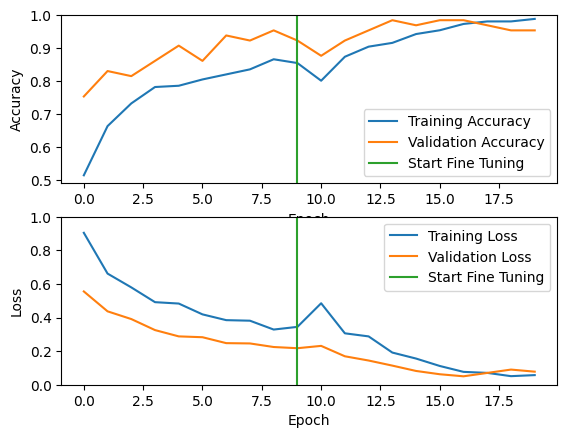

In [18]:
plt.subplot(2, 1, 1)
plt.plot(accuracy, label="Training Accuracy")
plt.plot(val_accuracy, label="Validation Accuracy")
plt.ylim([min(plt.ylim()), 1])
plt.plot([INITIAL_EPOCHS-1, INITIAL_EPOCHS-1], plt.ylim(), label="Start Fine Tuning")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.ylim([0, 1])
plt.plot([INITIAL_EPOCHS-1, INITIAL_EPOCHS-1], plt.ylim(), label="Start Fine Tuning")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='upper right')

plt.show()

## Evaluation and prediction

Model prediction on images from train dataset

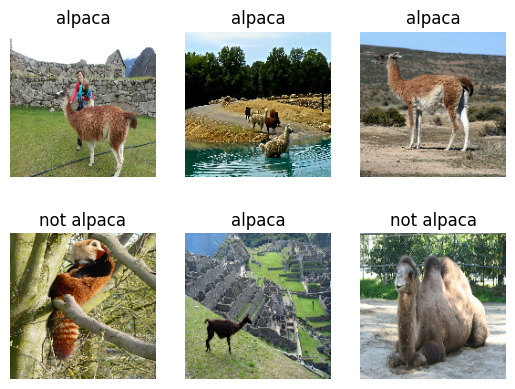

In [19]:
image_batch, label_batch = train_dataset.as_numpy_iterator().next()

predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.axis('off')
    plt.imshow(image_batch[i].astype('uint8'))
    plt.title(class_names[predictions[i]])

Model prediction on random images

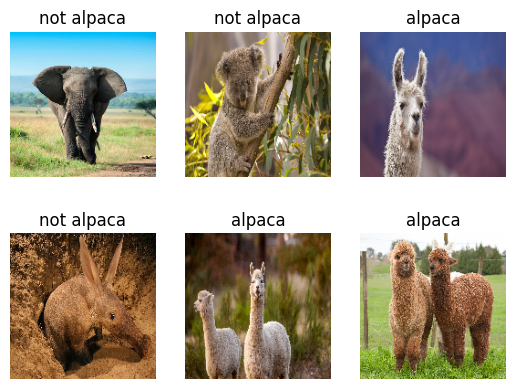

In [20]:
TEST_IMAGES_PATH = "alpaca_test_images/"
TEST_IMAGES = [
    "image_1.jpg",
    "image_2.jpg",
    "image_3.jpg",
    "image_4.jpg",
    "image_5.jpg",
    "image_6.jpg",
]

images = []
for i in range(6):
    image = tf.keras.utils.load_img(path=TEST_IMAGES_PATH+TEST_IMAGES[i], target_size=IMAGE_SIZE)
    image = tf.keras.utils.img_to_array(image)
    images.append(image)
image_batch = np.array(images)

predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.axis('off')
    plt.imshow(image_batch[i].astype('uint8'))
    plt.title(class_names[predictions[i]])